## Import

In [1]:
import numpy as np
import pandas as pd
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from ann_visualizer.visualize import ann_viz
import graphviz  
import random
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

Récupération des données et réglage de l'affichage :

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
data.head()

,initiator,target,protocol,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,range_skew,ranging_unit,ranging_error,loc_initiator_x,loc_initiator_y,loc_initiator_z,loc_target_x,loc_target_y,loc_target_z,distance,course_dist,temperature_initiator,temperature_target,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,register_dump_CIR
0,183,100,TWR,2.783982,946218857614,946490292658,946594234510,946322802711,-2.368804,1622,1745.608935,7.607739,8.187508,m,0.226,2.12,2.793,2.65,-3.962,7.931,2.65,7.962,0.0,30.98,30.220001,1654929794228,4,-80.136574,-80.077130,-79.836296,-80.016667,"{""ACC_MEM"": ""AAT/9gACAAr/+wABAAL/8wAS//AACgAGA..."
1,183,100,TWR,2.920485,1009474709646,1009746235572,1009850439822,1009578917162,-1.045965,1633,1687.497019,7.659333,7.914943,m,-0.047,2.12,2.793,2.65,-3.962,7.931,2.65,7.962,0.0,30.98,29.840002,1654929795219,10,-80.267769,-79.988684,-79.835720,-80.030724,"{""ACC_MEM"": ""//gAEwAC//X/9gAXABEACwASABQAFgAG/..."
2,183,100,TWR,2.536090,1072923068046,1073194681670,1073299179662,1073027569304,-0.799856,1633,1674.791667,7.659333,7.855350,m,-0.106,2.12,2.793,2.65,-3.962,7.931,2.65,7.962,0.0,30.98,29.840002,1654929796210,16,-79.964310,-79.850138,-79.693502,-79.835983,"{""ACC_MEM"": ""//QABQAJ//X/9gAUABMADv/3//r//gAK/..."
3,183,100,TWR,2.857669,36731534990,37003232943,37107270798,36835576116,-0.984438,1635,1686.709409,7.668714,7.911249,m,-0.051,2.12,2.793,2.65,-3.962,7.931,2.65,7.962,0.0,30.98,29.840002,1654929797201,22,-80.040833,-79.818313,-79.849525,-79.902890,"{""ACC_MEM"": ""ACb//AAa//4ADQAJAAYALf/+ABQAEgAOA..."
4,183,100,TWR,2.263103,99923195534,100194974620,100298828942,100027053147,-0.769092,1645,1685.436774,7.715617,7.905280,m,-0.056,2.12,2.793,2.65,-3.962,7.931,2.65,7.962,0.0,30.98,29.840002,1654929798190,28,-79.999908,-80.102552,-80.022316,-80.041592,"{""ACC_MEM"": ""//b/+P/6//3/8QAI//H//P/1AAkAAv/3A..."


In [40]:
#data importation 
data_1 = pd.read_csv(r"/home/sid2019-22/Téléchargements/Dataset_complete.csv")
data_0 = pd.read_csv(r"/home/sid2019-22/Téléchargements/positions.csv")
extract_orientation = data_0[['node_id','orientation']]
extract_orientation.rename(columns={"node_id": "target"}, inplace=True)
data = data_1.merge(extract_orientation,how='left', on = 'target')
#knn

## Remplacer les -inf par la moyenne de la colonne

In [44]:
# REMPLACER data par votre jeu de données
a = - np.inf # on récupère la valeur -inf puisque '-inf' n'est pas reconnu par jupyter


moy = [] # on calcul la moyenne de chaque colonne privée des valeurs de -inf

for j in range(27,31): #les valeurs de -inf sont de 27 à 31
    liste = []
    for i in range(len(data.columns[j])):
        if data.iloc[i,j] != a:
            liste.append(data.iloc[i,j])
    moy.append(np.mean(liste))

data_col_inf = data.columns[27:31] #on récupère le nom des colonnes ayant des infs

i=0
for j in data_col_inf: #pour chacune de ces colonnes 
    data[j].replace(a, moy[i],inplace=True) # on remplace les valeurs de - inf par la moyenne de la colonne
    i = i + 1

## Analyse rapide

Première matrice de corrélation

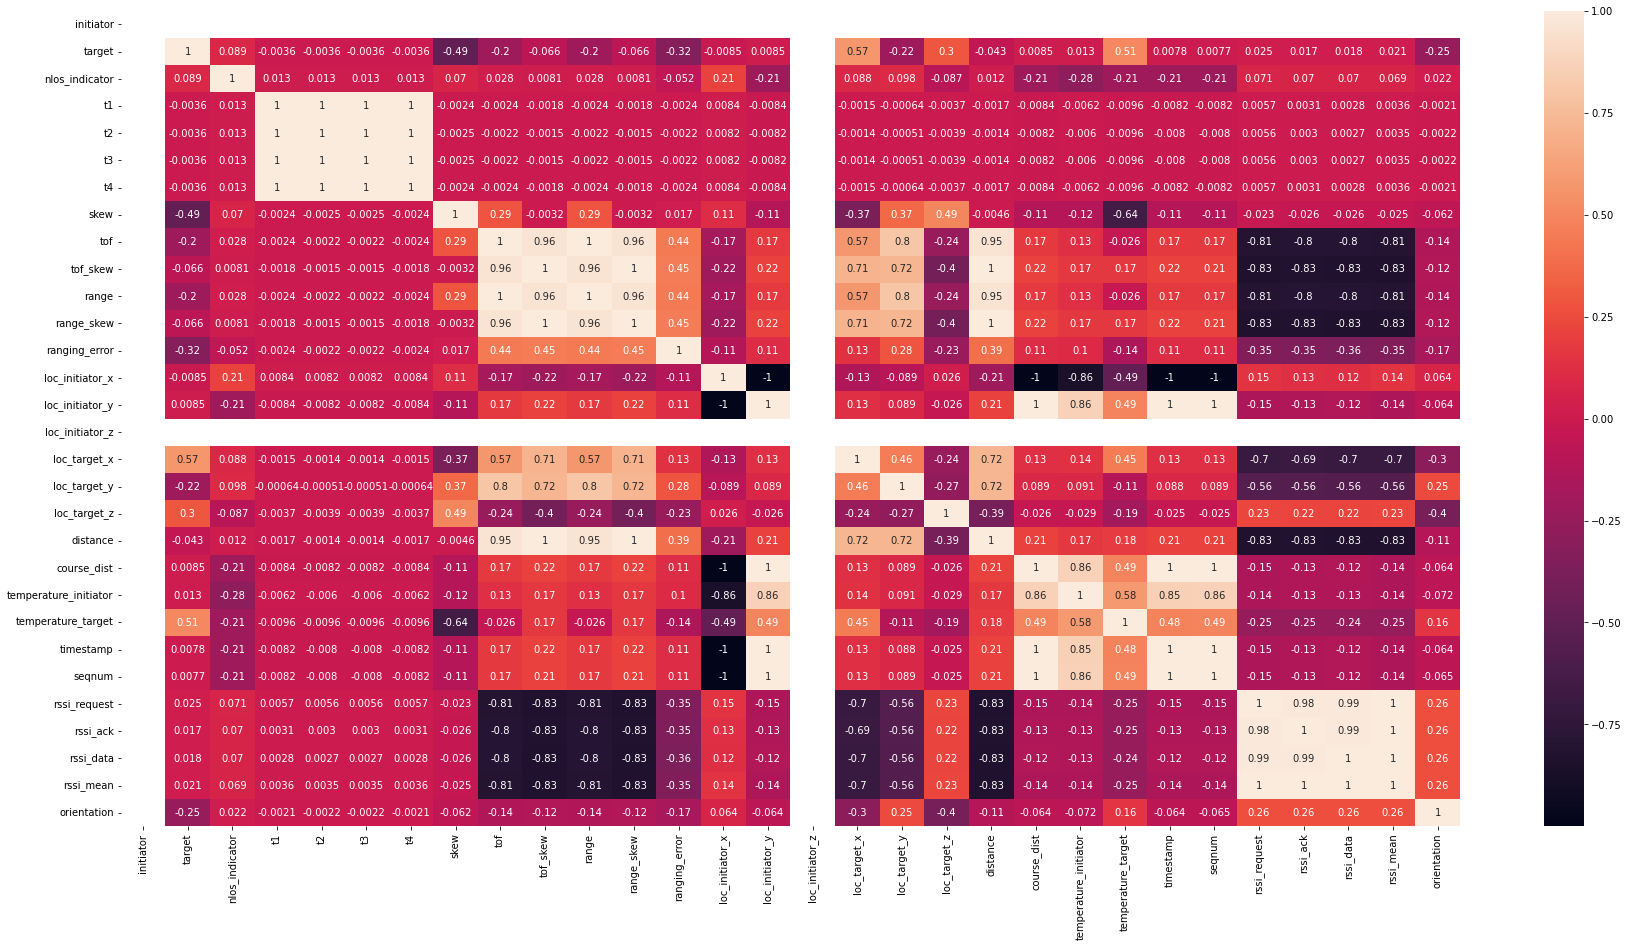

In [5]:
plt.figure(figsize=(30, 15))
test = sns.heatmap(data.corr(), annot=True)
plt.show()

Calcul du nombre de valeurs nulles pour chaque varaiables :

In [43]:
data.isnull().sum()

initiator                0
target                   0
protocol                 0
nlos_indicator           0
t1                       0
t2                       0
t3                       0
t4                       0
skew                     0
tof                      0
tof_skew                 0
range                    0
range_skew               0
ranging_unit             0
ranging_error            0
loc_initiator_x          0
loc_initiator_y          0
loc_initiator_z          0
loc_target_x             0
loc_target_y             0
loc_target_z             0
distance                 0
course_dist              0
temperature_initiator    0
temperature_target       0
timestamp                0
seqnum                   0
rssi_request             0
rssi_ack                 0
rssi_data                0
rssi_mean                0
register_dump_CIR        0
orientation              0
dtype: int64

### Tentative de retrouver la distance à l'aide des 't'

In [72]:
# la formule est : t4 - t1 - (t3 - t2)        / 2

test = data.iloc[0]

print((test['t4'] - test['t1'] -( test['t3'] - test['t2'] ))/2)
print('on veut:',test['range'])

(test['t4'] - test['t1'] - (1-test['skew'] * 10**(-6))*( test['t3'] - test['t2'] ))/2

1622.5
on veut: 7.607739


1499.3910626024008

## simplification des variables

In [79]:
data_corr=data.drop(['loc_initiator_z','ranging_unit','protocol','initiator','target'], axis=1).corr() # on retire les variables
#étant toujours identitiques donc inintéressantes
isole = []
for nom in data_corr.columns :
    correl = []
    for i in range(len(data_corr.columns)):

        if abs(data_corr[nom][i]) > 0.6 and nom != data_corr.columns[i] :
            correl.append(data_corr.columns[i])
    if correl != []:
        print('Les variables corrélées avec ',nom,' sont :', correl,'\n')
    else:
        print("Aucune variable n'est corrélée avec ", nom, '\n')
        isole.append(nom)
data_clear = data_corr.drop(isole,axis=1)

Aucune variable n'est corrélée avec  nlos_indicator 

Les variables corrélées avec  t1  sont : ['t2', 't3', 't4'] 

Les variables corrélées avec  t2  sont : ['t1', 't3', 't4'] 

Les variables corrélées avec  t3  sont : ['t1', 't2', 't4'] 

Les variables corrélées avec  t4  sont : ['t1', 't2', 't3'] 

Les variables corrélées avec  skew  sont : ['temperature_target'] 

Les variables corrélées avec  tof  sont : ['tof_skew', 'range', 'range_skew', 'loc_target_y', 'distance', 'rssi_request', 'rssi_ack', 'rssi_data', 'rssi_mean'] 

Les variables corrélées avec  tof_skew  sont : ['tof', 'range', 'range_skew', 'loc_target_x', 'loc_target_y', 'distance', 'rssi_request', 'rssi_ack', 'rssi_data', 'rssi_mean'] 

Les variables corrélées avec  range  sont : ['tof', 'tof_skew', 'range_skew', 'loc_target_y', 'distance', 'rssi_request', 'rssi_ack', 'rssi_data', 'rssi_mean'] 

Les variables corrélées avec  range_skew  sont : ['tof', 'tof_skew', 'range', 'loc_target_x', 'loc_target_y', 'distance', 'rssi_

In [80]:
isole # représente les variables corrélés avec aucune autre variable

['nlos_indicator', 'ranging_error', 'loc_target_z']

affichage de la nouvelle matrice de corrélation simplifiée :

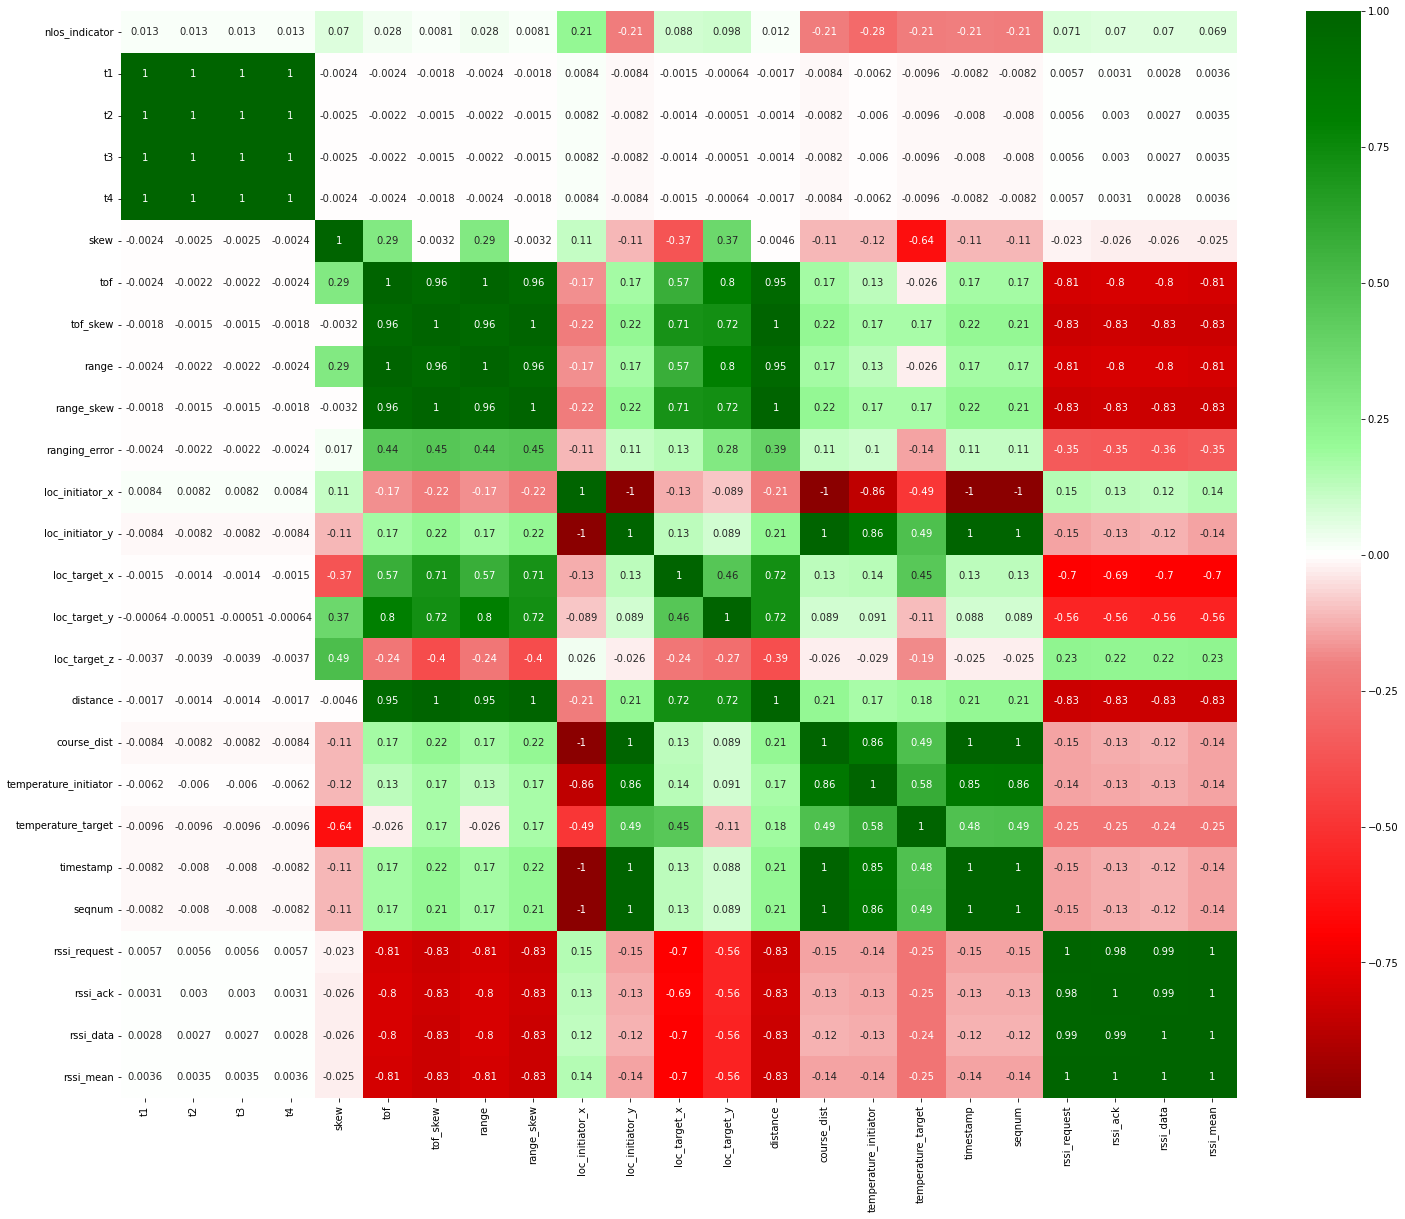

In [81]:
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
GnRd=LinearSegmentedColormap.from_list('rg',l, N=256)
plt.figure(1,figsize = (25, 20))
ax = sns.heatmap(data_clear, annot=True,cmap=GnRd)

Les t sont tous très corrélés
TOF et tout ce qui a un rapport avec la distance ainsi que les localisations du client aussi
tous les rssi aussi qui sont négativement corrélés avec tout se qui est corrélé avec distance

### ACP (pas fini)

[0.36779627 0.21128142 0.14812383]
0.7272015258307077


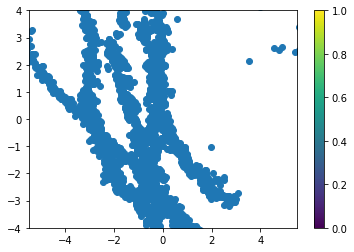

In [315]:
data_acp = data.select_dtypes(['number'])
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(data_acp)
X_scaled = std_scale.transform(data_acp)

from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt


# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1])

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()

(-0.7, 0.7)

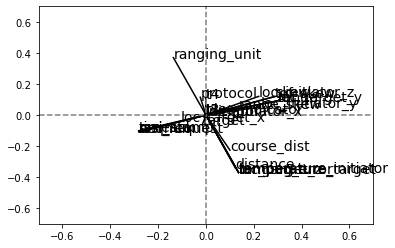

In [317]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, data.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

In [12]:
data.describe()

,initiator,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,range_skew,ranging_error,loc_initiator_x,loc_initiator_y,loc_initiator_z,loc_target_x,loc_target_y,loc_target_z,distance,course_dist,temperature_initiator,temperature_target,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,orientation
count,3946.0,3946.000000,3946.000000,3.946000e+03,3.946000e+03,3.946000e+03,3.946000e+03,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3.946000e+03,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3.946000e+03,3946.00000,3931.000000,3938.000000,3943.000000,3929.000000,3946.000000
mean,183.0,148.315256,7.215384,5.505930e+11,5.509284e+11,5.510320e+11,5.506966e+11,-2.755970,999.946275,1142.269047,4.690093,5.357636,0.045333,0.365008,5.955793,2.650000e+00,1.452085,5.878422,2.651427,5.312293,3.617079,39.577380,39.555326,1.654930e+12,2200.96072,-80.941627,-80.891527,-80.807031,-80.837118,81.495692
std,0.0,35.805126,19.476255,3.164409e+11,3.164412e+11,3.164412e+11,3.164409e+11,3.762459,674.344209,646.710484,3.162907,3.033295,0.229559,0.983370,1.772241,1.958682e-13,5.091560,2.249992,0.003063,2.936111,2.026785,2.341864,3.782210,3.017928e+05,1216.14462,5.107137,4.762960,4.697365,4.746466,96.093454
min,183.0,100.000000,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-2.875181,-0.715185,-0.792000,-1.276000,2.793000,2.650000e+00,-3.962000,2.793000,2.650000,0.000000,0.000000,30.410000,27.559999,1.654930e+12,1.00000,-103.732994,-103.808854,-103.579258,-103.099984,0.000000
25%,183.0,101.000000,2.956510,2.778704e+11,2.782606e+11,2.783633e+11,2.779731e+11,-5.783573,655.250000,715.863760,3.073348,3.357648,-0.103000,-0.500000,4.454000,2.650000e+00,-3.132000,4.339000,2.650000,3.323000,1.899738,38.959999,36.680000,1.654930e+12,1174.25000,-79.961129,-79.984200,-79.882344,-79.875913,0.000000
50%,183.0,171.000000,3.524929,5.528798e+11,5.532044e+11,5.533074e+11,5.529824e+11,-1.784294,898.000000,998.316717,4.211930,4.682450,0.033000,0.325000,6.028000,2.650000e+00,-1.190000,4.578000,2.650000,4.639000,3.699628,40.384998,39.340000,1.654930e+12,2231.50000,-79.218109,-79.304879,-79.218111,-79.230778,90.000000
75%,183.0,180.000000,4.342234,8.238901e+11,8.243201e+11,8.244236e+11,8.239937e+11,0.338401,1222.000000,1355.367840,5.731602,6.357142,0.174000,1.198000,7.514000,2.650000e+00,6.169000,7.931000,2.650000,6.312000,5.399282,41.240002,42.380001,1.654931e+12,3251.75000,-78.659592,-78.698918,-78.666953,-78.683458,119.000000
max,183.0,184.000000,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,12.363750,13.415278,1.432000,2.120000,8.914000,2.650000e+00,11.442000,9.249000,2.658000,12.722000,6.999961,42.380001,47.320004,1.654931e+12,4260.00000,-77.162437,-77.516188,-77.428716,-77.478065,270.000000


### Partie de Lauriane

In [296]:
data

,initiator,target,protocol,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,range_skew,ranging_unit,ranging_error,loc_initiator_x,loc_initiator_y,loc_initiator_z,loc_target_x,loc_target_y,loc_target_z,distance,course_dist,temperature_initiator,temperature_target,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,register_dump_CIR
0,183,100,TWR,2.783982,946218857614,946490292658,946594234510,946322802711,-2.368804,1622,1745.608935,7.607739,8.187508,m,0.226,2.120,2.793,2.65,-3.962,7.931,2.65,7.962,0.000000,30.980000,30.220001,1654929794228,4,-80.136574,-80.077130,-79.836296,-80.016667,"{""ACC_MEM"": ""AAT/9gACAAr/+wABAAL/8wAS//AACgAGA..."
1,183,100,TWR,2.920485,1009474709646,1009746235572,1009850439822,1009578917162,-1.045965,1633,1687.497019,7.659333,7.914943,m,-0.047,2.120,2.793,2.65,-3.962,7.931,2.65,7.962,0.000000,30.980000,29.840002,1654929795219,10,-80.267769,-79.988684,-79.835720,-80.030724,"{""ACC_MEM"": ""//gAEwAC//X/9gAXABEACwASABQAFgAG/..."
2,183,100,TWR,2.536090,1072923068046,1073194681670,1073299179662,1073027569304,-0.799856,1633,1674.791667,7.659333,7.855350,m,-0.106,2.120,2.793,2.65,-3.962,7.931,2.65,7.962,0.000000,30.980000,29.840002,1654929796210,16,-79.964310,-79.850138,-79.693502,-79.835983,"{""ACC_MEM"": ""//QABQAJ//X/9gAUABMADv/3//r//gAK/..."
3,183,100,TWR,2.857669,36731534990,37003232943,37107270798,36835576116,-0.984438,1635,1686.709409,7.668714,7.911249,m,-0.051,2.120,2.793,2.65,-3.962,7.931,2.65,7.962,0.000000,30.980000,29.840002,1654929797201,22,-80.040833,-79.818313,-79.849525,-79.902890,"{""ACC_MEM"": ""ACb//AAa//4ADQAJAAYALf/+ABQAEgAOA..."
4,183,100,TWR,2.263103,99923195534,100194974620,100298828942,100027053147,-0.769092,1645,1685.436774,7.715617,7.905280,m,-0.056,2.120,2.793,2.65,-3.962,7.931,2.65,7.962,0.000000,30.980000,29.840002,1654929798190,28,-79.999908,-80.102552,-80.022316,-80.041592,"{""ACC_MEM"": ""//b/+P/6//3/8QAI//H//P/1AAkAAv/3A..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,183,184,TWR,3.075243,301428484750,302000434919,302102988430,301531040251,-9.382925,995,1476.125937,4.666893,6.923540,m,-0.076,-1.276,8.914,2.65,2.120,2.793,2.65,7.000,6.999961,41.810001,46.939999,1654930833773,4231,-80.229179,-79.428015,-79.342829,-79.666674,"{""ACC_MEM"": ""ABH//QAT//YABQASAAIAFwAUAAsAAv/3A..."
3942,183,184,TWR,3.085177,375355600014,375928251294,376031194254,375458544956,-8.306196,991,1418.532184,4.648132,6.653405,m,-0.347,-1.276,8.914,2.65,2.120,2.793,2.65,7.000,6.999961,41.525002,47.319996,1654930834930,4237,-80.196487,-79.576395,-79.985511,-79.919464,"{""ACC_MEM"": ""ABkADQAOAAgABv/7ABgABAAG//n////w/..."
3943,183,184,TWR,2.674524,449294310542,449867663034,449970544782,449397194279,-8.952233,994,1455.010695,4.662203,6.824502,m,-0.175,-1.276,8.914,2.65,2.120,2.793,2.65,7.000,6.999961,41.810001,46.939999,1654930836088,4243,-80.158638,-79.435472,-79.234453,-79.609521,"{""ACC_MEM"": ""AA8AAQAE/////P/zABz/+P////8AAwAAA..."
3944,183,184,TWR,2.727551,523279420046,523853474064,523955982478,523381930458,-8.490778,999,1434.188082,4.685655,6.726837,m,-0.273,-1.276,8.914,2.65,2.120,2.793,2.65,7.000,6.999961,41.240002,46.559998,1654930837246,4249,-80.229492,-79.554364,-79.599858,-79.794571,"{""ACC_MEM"": ""ABoACwAEABEACQADAAL//wAPAAYAFP/4A..."
